# Analyse BlueSeis BSPF Event Analysis - Backazimuth

With pressure sensor parascientific and new sensor 

In [1]:
import os 
import obspy as obs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from andbro__store_as_pickle import __store_as_pickle
from andbro__savefig import __savefig

## Configurations

In [2]:
workdir = "/home/andbro/Documents/ROMY/BSPF"

In [3]:
config = {}

## blueSeis sensor
config['seed_blueseis'] = "PY.BSPF..HJ*"

## Trillium 240 next to BlueSeis on Pier
config['seed_seismometer'] = "II.PFO.10.BH*" 
# config['seed_seismometer'] = "PY.PFOIX..HH*" 

## BSPF coordinates
config['BSPF_lon'] = -116.455439
config['BSPF_lat'] = 33.610643


## Borrego Springs, Ca M3.2 -> good
# config['tbeg'] = obs.UTCDateTime("2023-01-09 19:42:56")-3
# config['tend'] = config['tbeg']+35
# config['fmin'], config['fmax'] = 0.1, 15.0
# config['magnitude'] = 3.2
# config['title'] = f"Borrego Springs, Ca | {config['tbeg'].date} {str(config['tbeg'].time)[:5]} UTC | M{config['magnitude']}"

## Las Brisas M6.2 -> alright
config['eventtime'] = obs.UTCDateTime("2022-11-22 16:39")
config['tbeg'] = obs.UTCDateTime("2022-11-22 16:32")+30
config['tend'] = config['tbeg']+1000
config['fmin'], config['fmax'] = 0.1, 2.0
config['magnitude'] = 6.3
config['title'] = f"Las Brisas, Mexico | {config['tbeg'].date} {str(config['tbeg'].time)[:5]} UTC | M{config['magnitude']}"

## Borrego Springs, California M4.2 -> good
# config['eventtime'] = obs.UTCDateTime("2022-12-31 12:12:26")
# config['tbeg'] = obs.UTCDateTime("2022-12-31 12:12:27")
# config['tend'] = obs.UTCDateTime("2022-12-31 12:13")
# config['magnitude'] = 4.2
# config['fmin'], config['fmax'] = 1.0, 10.0
# config['title'] = f"Borrego Springs, Ca | {config['tbeg'].date} {str(config['tbeg'].time)[:5]} UTC | M{config['magnitude']}"

## store config
__store_as_pickle(config, f"./configs/{str(config['tbeg'].date).replace('-','')}_M{config['magnitude']}.pkl")

## Load Data

In [4]:
def __request_data(seed, tbeg, tend):

    from obspy.clients.fdsn import Client

    client = Client("IRIS")

    net, sta, loc, cha = seed.split(".")

    try:
        inventory = client.get_stations(network=net, 
                                         station=sta,
                                         starttime=tbeg,
                                         endtime=tend,
                                         level="response",
                                         )
    except:
        print("Failed to load inventory!")
        inventory = None
        
    try:
        waveform = client.get_waveforms(network=net,
                                       station=sta,
                                       location=loc,
                                       channel=cha, 
                                       starttime=tbeg-60,
                                       endtime=tend+60,
                                       )

    except:
        print("Failed to load waveforms!")
        waveform = None
    
    return waveform, inventory

In [5]:
py_bspf0, py_bspf_inv = __request_data(config['seed_blueseis'], config['tbeg'], config['tend'])

In [ ]:
ii_pfo0, ii_pfo_inv = __request_data(config['seed_seismometer'], config['tbeg'], config['tend'])

In [ ]:
# ii_pfo_inv.write("/home/andbro/Downloads/ii_pfo.xml", format="STATIONXML")

## PreProcessing

In [ ]:
def __process_acc_data(config, st, inv):
    
    ii_pfo_acc = st.copy()

    pre_filt = [0.005, 0.01, 19, 20]

    ## cut properly
    ii_pfo_acc.trim(config['tbeg'], config['tend'])

    ## demean
    ii_pfo_acc.detrend("demean")

    ## remove response
    ii_pfo_acc.remove_response(inventory=inv, 
                           pre_filt=pre_filt, 
                           output="ACC",
#                            water_level=60, 
                           plot=False)

    ## taper 
    ii_pfo_acc.taper(0.1)

    ## bandpass
    ii_pfo_acc.filter("bandpass", freqmin=config['fmin'], freqmax=config['fmax'], corners=8, zerophase=True)

    ## remove mean
    ii_pfo_acc.detrend("demean")
    
    ## adjust channel names
    for tr in ii_pfo_acc:
        if tr.stats.channel[-1] == "1":
            tr.stats.channel = str(tr.stats.channel).replace("1","N")
        if tr.stats.channel[-1] == "2":
            tr.stats.channel = str(tr.stats.channel).replace("2","E")

    ## show stream
    print(ii_pfo_acc)
            
    ii_pfo_acc.plot(equal_scale=False);
    
    return ii_pfo_acc

3 Trace(s) in Stream:
II.PFO.10.BHN | 2022-11-22T16:32:29.994538Z - 2022-11-22T16:49:09.994538Z | 40.0 Hz, 40001 samples
II.PFO.10.BHE | 2022-11-22T16:32:29.994538Z - 2022-11-22T16:49:09.994538Z | 40.0 Hz, 40001 samples
II.PFO.10.BHZ | 2022-11-22T16:32:29.994538Z - 2022-11-22T16:49:09.994538Z | 40.0 Hz, 40001 samples


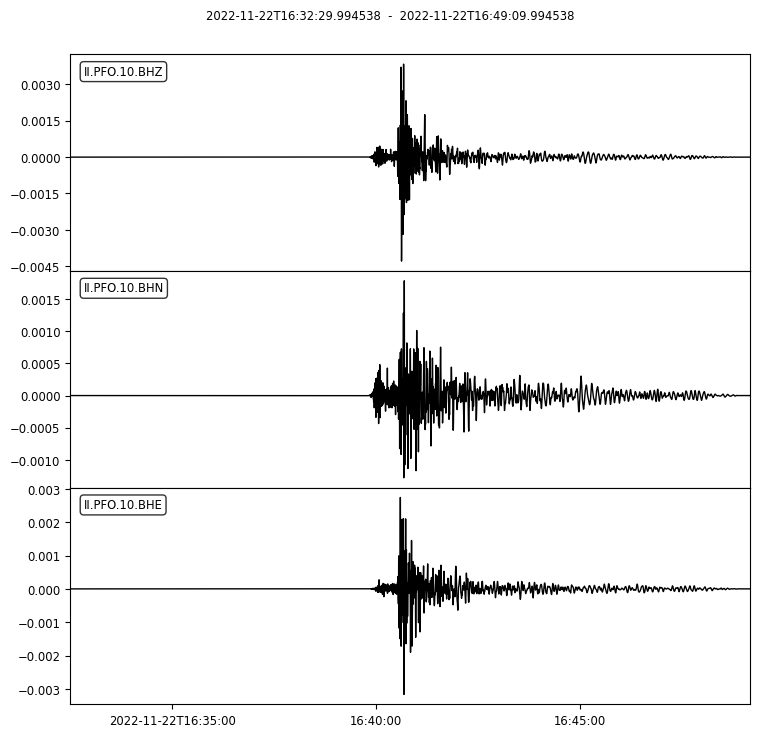

In [8]:
ii_pfo_acc = __process_acc_data(config, ii_pfo0, ii_pfo_inv)

In [9]:
def __process_rot_data(config, st, inv):
    
    py_bspf = st.copy()

    ## merge traces that might be split due to data gaps or overlaps
    py_bspf.merge(fill_value="interpolate")

    ## renove sensitivity
    py_bspf.remove_sensitivity(inv)
    
    ## resample to 40 Hz as acc data
    py_bspf.resample(40)
    
    ## cut to event
    py_bspf.trim(config['tbeg'], config['tend'])
    
    ## remove mean
    py_bspf.detrend("demean")

    ## apply taper
    py_bspf.taper(0.1)

    ## bandpass filter
    py_bspf.filter("bandpass", freqmin=config['fmin'], freqmax=config['fmax'], corners=8, zerophase=True)

    ## remove mean
    py_bspf.detrend("demean")    
    

    
    ## adjust channel names
    for tr in py_bspf:
        if tr.stats.channel[-1] == "1":
            tr.stats.channel = str(tr.stats.channel).replace("1","E")
        if tr.stats.channel[-1] == "2":
            tr.stats.channel = str(tr.stats.channel).replace("2","N")        
        if tr.stats.channel[-1] == "3":
            tr.stats.channel = str(tr.stats.channel).replace("3","Z")

    ## show all traces in data stream
    print(py_bspf)

    py_bspf.plot(equal_scale=False);

    return py_bspf

3 Trace(s) in Stream:
PY.BSPF..HJE | 2022-11-22T16:32:30.001000Z - 2022-11-22T16:49:10.001000Z | 40.0 Hz, 40001 samples
PY.BSPF..HJN | 2022-11-22T16:32:30.001000Z - 2022-11-22T16:49:10.001000Z | 40.0 Hz, 40001 samples
PY.BSPF..HJZ | 2022-11-22T16:32:30.001000Z - 2022-11-22T16:49:10.001000Z | 40.0 Hz, 40001 samples


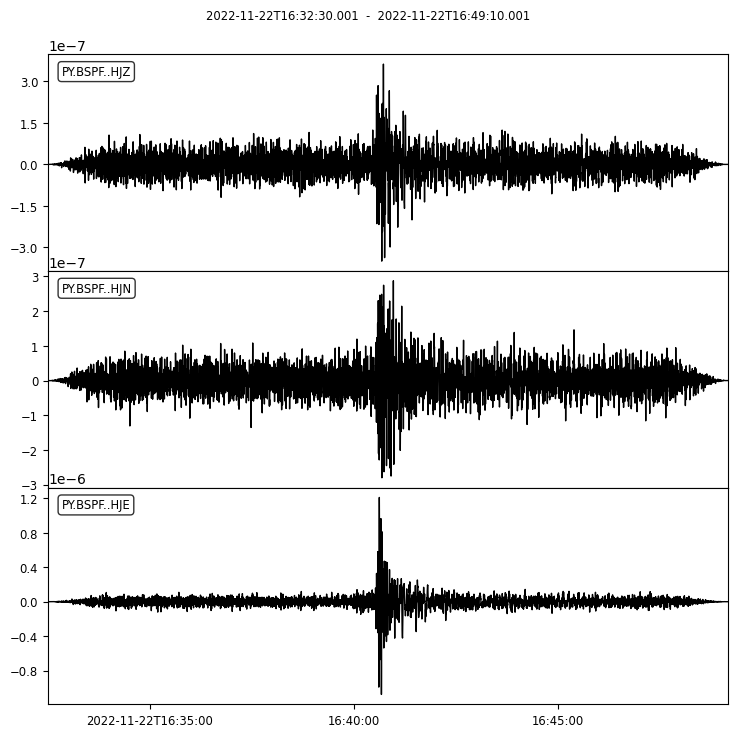

In [10]:
py_bspf = __process_rot_data(config, py_bspf0, py_bspf_inv)

In [11]:
ii_pfo_acc, py_bspf

(3 Trace(s) in Stream:
II.PFO.10.BHN | 2022-11-22T16:32:29.994538Z - 2022-11-22T16:49:09.994538Z | 40.0 Hz, 40001 samples
II.PFO.10.BHE | 2022-11-22T16:32:29.994538Z - 2022-11-22T16:49:09.994538Z | 40.0 Hz, 40001 samples
II.PFO.10.BHZ | 2022-11-22T16:32:29.994538Z - 2022-11-22T16:49:09.994538Z | 40.0 Hz, 40001 samples,
 3 Trace(s) in Stream:
PY.BSPF..HJE | 2022-11-22T16:32:30.001000Z - 2022-11-22T16:49:10.001000Z | 40.0 Hz, 40001 samples
PY.BSPF..HJN | 2022-11-22T16:32:30.001000Z - 2022-11-22T16:49:10.001000Z | 40.0 Hz, 40001 samples
PY.BSPF..HJZ | 2022-11-22T16:32:30.001000Z - 2022-11-22T16:49:10.001000Z | 40.0 Hz, 40001 samples)

## BAZ Computations 1

In [12]:
config['station_longitude'] = config['BSPF_lon']
config['station_latitude']  = config['BSPF_lat']

config['win_length_sec'] = 5   ## window length for correlation
config['step'] = 2
config['overlap'] = 50

In [13]:
from functions.compute_backazimuth import __compute_backazimuth

In [14]:
# def __compute_backazimuth(st_acc, st_rot, config, wave_type="love", event=None, plot=True, show_details=False):
    
#     import matplotlib as mpl
    
#     from numpy import ones, arange, linspace, asarray, array, meshgrid, round
#     from pprint import pprint
#     from obspy import read, read_events, UTCDateTime
#     from obspy.clients.fdsn import Client
#     from obspy.geodetics.base import gps2dist_azimuth
#     from obspy.signal.cross_correlation import xcorr
#     from obspy.signal.rotate import rotate_ne_rt

#     ## _______________________________    
#     ## check config
#     keywords=['tbeg','tend','station_latitude', 'station_longitude',
#               'step', 'win_length_sec', 'overlap', 'eventtime']

#     for key in keywords: 
#         if key not in config.keys():
#             print(f" -> {key} is missing in config!\n")
#             pprint(keywords)
#             return
            
#     ## _______________________________    
#     ## Defaults
#     if 'win_length_sec' not in config.keys():
#         config['win_length_sec'] = .5    ## window length for correlation
#     if 'step' not in config.keys():
#         config['step'] = 1
#     if 'overlap' not in config.keys():
#         config['overlap'] = 25
    
    
#     ## time period
#     config['tbeg'], config['tend'] = UTCDateTime(config['tbeg']), UTCDateTime(config['tend'])

#     ## _______________________________    
#     ## prepare streams
#     ACC = st_acc.copy().trim(config['tbeg'], config['tend'])
#     ROT = st_rot.copy().trim(config['tbeg'], config['tend'])
        
#     ## _______________________________    
#     ## get event if not provided
#     if not event:
#         events = Client("USGS").get_events(starttime=config['eventtime']-20, endtime=config['eventtime']+20)
#         if len(events) > 1:
#             print(f" -> {len(events)} events found!!!")
#             print(events)
            
#     event = events[0]
    
#     ## event location from event info
#     config['source_latitude'] = event.origins[0].latitude
#     config['source_longitude'] = event.origins[0].longitude
    
#     if show_details:
#         print(" -> event used for theoretical backazimuth:")
#         print(" -> ", event.event_descriptions[0]['type'], ': ',event.event_descriptions[0]['text'] + "\n")
    

#     ## _______________________________        
#     ## theoretical backazimuth and distance
    
#     config['baz'] = gps2dist_azimuth(
#                                     config['source_latitude'], config['source_longitude'], 
#                                     config['station_latitude'], config['station_longitude'],
#                                     )
#     if show_details:
#         print(f" -> Epicentral distance [m]:       {round(config['baz'][0],1)}")
#         print(f" -> Theoretical azimuth [deg]:     {round(config['baz'][1],1)}")
#         print(f" -> Theoretical backazimuth [deg]: {round(config['baz'][2],1)}")

#     ## _______________________________    
#     ## backazimuth estimation with Love or Rayleigh waves
    
#     config['sampling_rate'] = int(ROT.select(channel="*Z")[0].stats.sampling_rate)
    
#     config['num_windows'] = len(ROT.select(channel="*Z")[0]) // (int(config['sampling_rate'] * config['win_length_sec']))

    
#     backas = linspace(0, 360 - config['step'], int(360 / config['step']))
   
#     corrbaz = []
    
#     ind = None
    
#     for i_deg in range(0, len(backas)):
        
#         for i_win in range(0, config['num_windows']):
            
#             ## infer indices
#             idx1 = int(config['sampling_rate'] * config['win_length_sec'] * i_win)
#             idx2 = int(config['sampling_rate'] * config['win_length_sec'] * (i_win + 1))
            
#             ## add overlap
#             if i_win > 0 and i_win < config['num_windows']:
#                 idx1 = int(idx1 - config['overlap']/100 * config['win_length_sec'] * config['sampling_rate'])
#                 idx2 = int(idx2 + config['overlap']/100 * config['win_length_sec'] * config['sampling_rate'])
            
#             ## prepare traces according to selected wave type
#             if wave_type == "love":
                
#                 if show_details and i_deg == 0 and i_win == 0:
#                     print("\n -> using Love waves for estimation ...")
                    
#                 ## rotate NE to RT   
#                 R, T = rotate_ne_rt(ACC.select(channel='*N')[0].data, 
#                                     ACC.select(channel='*E')[0].data,
#                                     backas[i_deg]
#                                    )

#                 ## compute correlation for backazimuth
#                 corrbaz0 = xcorr(ROT.select(channel="*Z")[0][idx1:idx2], 
#                                  T[idx1:idx2], 0,
#                                   )
                
#             elif wave_type == "rayleigh":
                
#                 if show_details and i_deg == 0 and i_win == 0:
#                     print("\n -> using Rayleigh waves for estimation ...")
                    
#                 ## rotate NE to RT   
#                 R, T = rotate_ne_rt(ROT.select(channel='*N')[0].data, 
#                                     ROT.select(channel='*E')[0].data,
#                                     backas[i_deg]
#                                    )

#                 ## compute correlation for backazimuth
#                 ## vertical acceleration has to be reversed for definition of polarization reasons
#                 corrbaz0 = xcorr(-1*ACC.select(channel="*Z")[0][idx1:idx2], 
#                                  T[idx1:idx2], 0,
#                                   )                
                
            
#             corrbaz.append(corrbaz0[1])

            
#     corrbaz = asarray(corrbaz)
#     corrbaz = corrbaz.reshape(len(backas), config['num_windows'])


#     ## extract maxima
#     maxcorr = array([backas[corrbaz[:, l1].argmax()] for l1 in range(0, config['num_windows'])])

#     ## create mesh grid
#     mesh = meshgrid(arange(config['win_length_sec']/2, config['win_length_sec'] * config['num_windows'], config['win_length_sec']), backas)

    

#     ## _______________________________
#     ## Plotting
#     def __makeplot():
        
#         ## define figure
#         fig, ax = plt.subplots(3, 1, figsize=(15, 10), sharex=True)

#         plt.subplots_adjust(hspace=0.1)
        
#         ## parameters
#         font = 18
#         acc_scaling, acc_unit = 1e3, "mm/s$^2$"
#         rot_scaling, rot_unit = 1e6, "$\mu$rad/s"

#         ## create time axis
#         time = np.linspace(0, len(ACC[0].data)/ACC[0].stats.sampling_rate, len(ACC[0].data))

#         ## plot vertical rotation rate
#         if wave_type == "love":
#             ax[0].plot(time, ROT.select(channel="*Z")[0].data*rot_scaling, label='vertical rotation rate')
#             ax[0].set_ylabel(f'vert. rot. rate \n({rot_unit})', fontsize=font)
#         elif wave_type == "rayleigh":
#             ax[0].plot(time, T*rot_scaling, label='transverse rotation rate')
#             ax[0].set_ylabel(f'trans. rot. rate \n({rot_unit})', fontsize=font)

 
#         ## plot transverse acceleration
#         if wave_type == "love":
#             ax[1].plot(time, T*acc_scaling, 'k',label='transverse acceleration')
#             ax[1].set_ylabel(f'transv. acc. \n({acc_unit})', fontsize=font)
#         elif wave_type == "rayleigh":
#             ax[1].plot(time, ACC.select(channel="*Z")[0].data*acc_scaling, 'k',label='vertical acceleration')
#             ax[1].set_ylabel(f'vert. acc. \n({acc_unit})', fontsize=font)                
            
        
#         ## backazimuth estimation plot
#         im = ax[2].pcolormesh(mesh[0], mesh[1], corrbaz, cmap=plt.cm.RdYlGn_r, vmin=-1, vmax=1, shading="auto")
#         ax[2].set_xlim(time[0], time[-1])
#         ax[2].set_ylim(0, 360)
#         ax[2].set_ylabel(u'estimated \n backazimuth (°)', fontsize=font)
#         ax[2].set_xlabel('time (s)', fontsize=font)

        
#         ## plot maximal correclation values
#         ax[2].plot(arange(config['win_length_sec']/2., config['win_length_sec'] * len(maxcorr), config['win_length_sec']), maxcorr, '.k')

        
#         ## plot theoretical Backazimuth for comparison
#         xx = arange(0, config['win_length_sec'] * len(maxcorr) + 1, config['win_length_sec'])
#         tba = ones(len(xx)) * config['baz'][2]
#         ax[2].plot(xx, tba, lw=1.5, alpha=0.7, color="k", ls="--")
    
    
#         ## add label for theoretical backazimuth
#         baz_label = u'Theor. BAz = '+str(round(config['baz'][2],2))+'°'
#         if config['baz'][2] < 330:
#             x_text, y_text = time[int(0.78*len(time))], config['baz'][2]+5
#         else:
#             x_text, y_text = time[int(0.78*len(time))], config['baz'][2]-15
#         ax[2].text(x_text, y_text, baz_label, color='k', fontsize=font-2)

        
#         ## epicentral distance
#         edist = round(config['baz'][0]/1000, 1)
        
        
#         ## adjust title
#         if 'fmin' in config.keys() and 'fmax' in config.keys():
#             ax[0].set_title(config['title'] +f" | {edist} km" + f" | {config['fmin']}-{config['fmax']} Hz", pad=15, fontsize=font)
#         else:
#             ax[0].set_title(config['title'] +f" | {edist} km", pad=15, fontsize=font)
 

#         ## tune tick size
#         for i in range(3):
#             ax[i].tick_params(axis="y", labelsize=13)
#             ax[i].tick_params(axis="x", labelsize=13)  
#             ax[i].set_xlim(time[0], time[-1])
        
#         ## add legends
#         ax[0].legend(loc=1, fontsize=font-2)
#         ax[1].legend(loc=1, fontsize=font-2)
        
#         ## adjust tick label style
#         ax[1].ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
        
               
#         ## add colorbar
#         cax = ax[2].inset_axes([1.01, 0., 0.02, 1])
#         cb1 = plt.colorbar(im, ax=ax[2], cax=cax)

#         plt.show();
        
    
#     if plot:
#         __makeplot();
        

#     ## _______________________________
#     ## prepare output        
    
#     output = {}
    
#     output['baz_mesh'] = mesh
#     output['baz_corr'] = corrbaz
#     output['baz_theo'] = config['baz']
#     output['acc_transverse'] = T
#     output['acc_radial'] = R
#     output['rot_vertical'] = ROT.select(channel="*Z")
#     output['event'] = event
    
#     return output

 -> event used for theoretical backazimuth:
 ->  earthquake name :  28 km SW of Las Brisas, Mexico

 -> Epicentral distance [m]:       312442.8
 -> Theoretical azimuth [deg]:     358.9
 -> Theoretical backazimuth [deg]: 178.9

 -> using Rayleigh waves for estimation ...


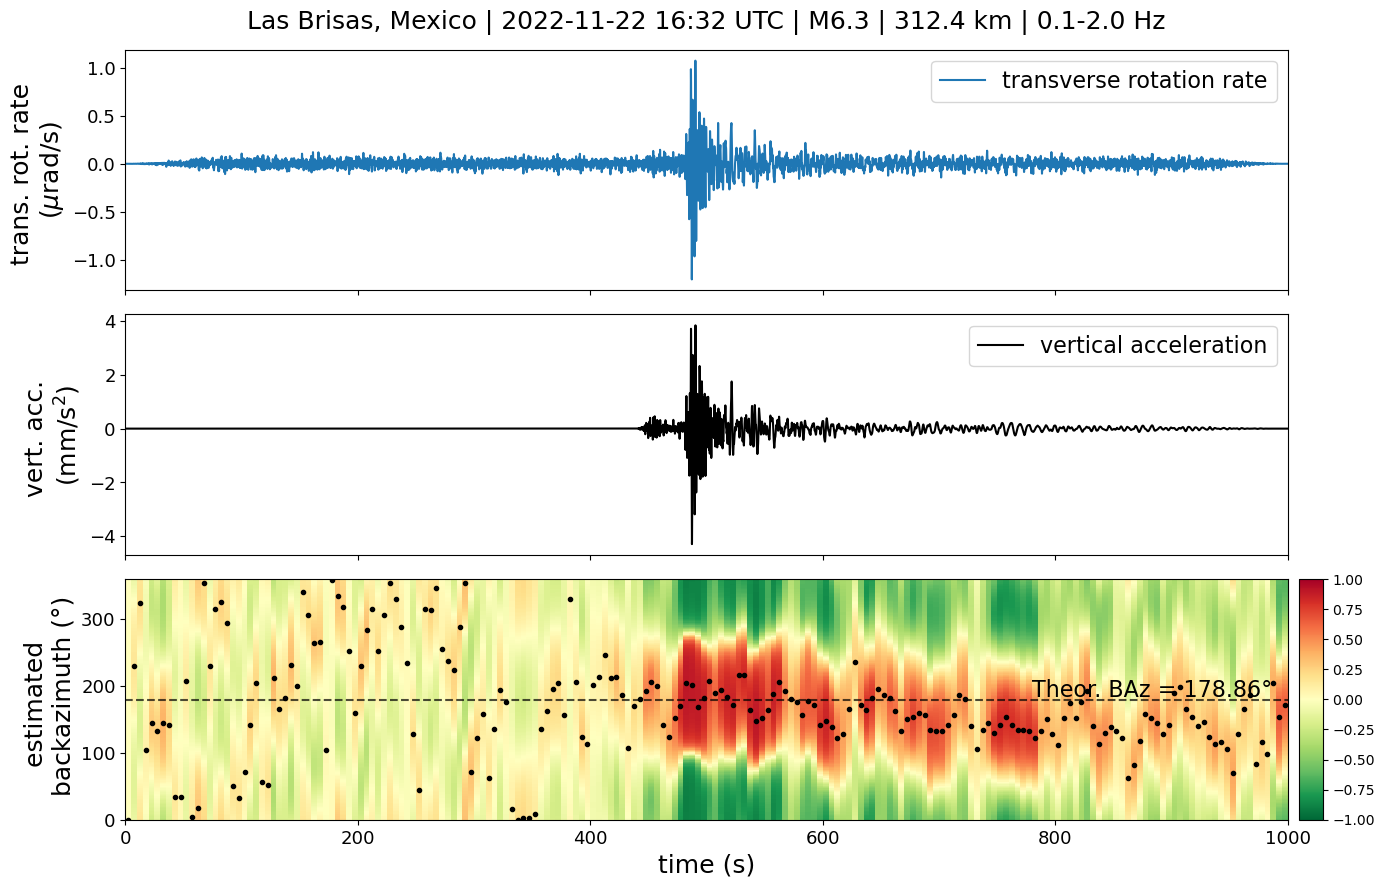

In [15]:
out = __compute_backazimuth(ii_pfo_acc, py_bspf, config, wave_type="love", plot=True, show_details=True)

In [16]:
# __savefig(out['fig'], "/home/andbro/Documents/LMU_Docs/EGU2023/", "M62_baz_rayleigh", mode="png", dpi=600)


   -> saving /home/andbro/Documents/LMU_Docs/EGU2023/M62_baz_rayleigh.png ...

   -> Done



In [17]:
# def __compute_backazimuth(st_acc, st_rot, config, event=None, plot=True):
    
#     import numpy as np
#     import matplotlib as mpl
    
#     from obspy import read, read_events, UTCDateTime
#     from obspy.clients.fdsn import Client
#     from obspy.geodetics.base import gps2dist_azimuth
#     from obspy.signal.cross_correlation import xcorr
#     from obspy.signal.rotate import rotate_ne_rt

#     ## _______________________________    
#     ## check config
#     keywords=['tbeg','tend','station_latitude', 'station_longitude',
#               'step', 'win_length_sec', 'overlap', 'eventtime']

#     for key in keywords: 
#         if key not in config.keys():
#             print(f" -> {key} is missing in config!\n")
            
            
#     ## _______________________________    
#     ## Defaults
#     if 'win_length_sec' not in config.keys():
#         config['win_length_sec'] = .5    ## window length for correlation
#     if 'step' not in config.keys():
#         config['step'] = 1
#     if 'overlap' not in config.keys():
#         config['overlap'] = 25
    
    
#     ## time period
#     config['tbeg'], config['tend'] = UTCDateTime(config['tbeg']), UTCDateTime(config['tend'])

#     ## _______________________________    
#     ## streams
#     ACC = st_acc.trim(config['tbeg'], config['tend'])
#     ROT = st_rot.trim(config['tbeg'], config['tend']).select(channel="*Z")
    
#     ## _______________________________    
#     ## get event if not provided
#     if not event:
#         events = Client("USGS").get_events(starttime=config['eventtime']-60, endtime=config['eventtime']+60)
#         if len(events) > 1:
#             print(f" -> {len(events)} events found!!!")
#             print(events)
            
#     event = events[0]
    
#     ## event location from event info
#     config['source_latitude'] = event.origins[0].latitude
#     config['source_longitude'] = event.origins[0].longitude
    
#     print(event.event_descriptions[0]['type'], ': ',event.event_descriptions[0]['text'] + "\n")
    

#     ## _______________________________        
#     ## theoretical backazimuth and distance
    
#     config['baz'] = gps2dist_azimuth(
#                                     config['source_latitude'], config['source_longitude'], 
#                                     config['station_latitude'], config['station_longitude'],
#                                     )

#     print('Epicentral distance [m]:       ',np.round(config['baz'][0],1))
#     print('Theoretical azimuth [deg]:     ', np.round(config['baz'][1],1))
#     print('Theoretical backazimuth [deg]: ', np.round(config['baz'][2],1))

#     ## _______________________________    
#     ## backazimuth estimation
    
#     config['sampling_rate'] = int(ROT.select(channel="*Z")[0].stats.sampling_rate)
    
#     config['num_windows'] = len(ROT.select(channel="*Z")[0]) // (int(config['sampling_rate'] * config['win_length_sec']))

    
#     backas = np.linspace(0, 360 - config['step'], int(360 / config['step']))
   
#     corrbaz = []
    
#     ind = None
    
#     for i_deg in range(0, len(backas)):
        
#         for i_win in range(0, config['num_windows']):
            
#             ## infer indices
#             idx1 = int(config['sampling_rate'] * config['win_length_sec'] * i_win)
#             idx2 = int(config['sampling_rate'] * config['win_length_sec'] * (i_win + 1))
            
#             ## add overlap
#             if i_win > 0 and i_win < config['num_windows']:
#                 idx1 = int(idx1 - config['overlap']/100 * config['win_length_sec'] * config['sampling_rate'])
#                 idx2 = int(idx2 + config['overlap']/100 * config['win_length_sec'] * config['sampling_rate'])
                    
#             ## rotate NE to RT   
#             R, T = rotate_ne_rt(ACC.select(channel='*N')[0].data, 
#                                 ACC.select(channel='*E')[0].data,
#                                 backas[i_deg]
#                                )
            
#             ## compute correlation for backazimuth
#             corrbaz0 = xcorr(ROT.select(channel="*Z")[0][idx1:idx2], 
#                              T[idx1:idx2], 0,
#                               )
            
#             corrbaz.append(corrbaz0[1])

            
#     corrbaz = np.asarray(corrbaz)
#     corrbaz = corrbaz.reshape(len(backas), config['num_windows'])


#     ## extract maxima
#     maxcorr = np.array([backas[corrbaz[:, l1].argmax()] for l1 in range(0, config['num_windows'])])

#     ## create mesh grid
#     mesh = np.meshgrid(np.arange(config['win_length_sec']/2, config['win_length_sec'] * config['num_windows'], config['win_length_sec']), backas)

    

#     ## _______________________________
#     ## Plotting
#     def __makeplot():
    
#         ## get rotated acceleration
#         R, T = rotate_ne_rt(ACC.select(component='N')[0].data, 
#                             ACC.select(component='E')[0].data,
#                             config['baz'][2]
#                            )

#         fig, ax = plt.subplots(3, 1, figsize=(15, 10))

#         ## parameters
#         font = 14
#         acc_scaling, acc_unit = 1e3, "mm/s$^2$"
#         rot_scaling, rot_unit = 1e6, "$\mu$rad/s"

#         ## create time axis
#         time = np.linspace(0, len(ACC[0].data)/ACC[0].stats.sampling_rate, len(ACC[0].data))

#         ## plot vertical rotation rate
#         ax[0].plot(time, ROT.select(channel="*Z")[0].data*rot_scaling, label='vertical rotation rate')

#         ax[0].set_xlim(time[0], time[-1])
#         ax[0].set_ylabel(f'vert. rot. rate \n({rot_unit})', fontsize=font)
#         ax[0].legend()

#         # add P- and S-wave arrivals
#         ROT_max = max(ROT.select(channel="*Z")[0].data*rot_scaling)
        
#         ## plot transverse acceleration
#         ax[1].plot(time, T*acc_scaling, 'k',label='transverse acceleration')
#         ax[1].set_xlim(time[0], time[-1])
#         ax[1].set_ylabel(f'transv. acc. \n({acc_unit})', fontsize=font)
#         ax[1].ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
#         ax[1].legend()
        

#         ## backazimuth estimation plot
#         im = ax[2].pcolormesh(mesh[0], mesh[1], corrbaz, cmap=plt.cm.RdYlGn_r, vmin=-1, vmax=1, shading="auto")
#         ax[2].set_xlim(time[0], time[-1])
#         ax[2].set_ylim(0, 360)
#         ax[2].set_ylabel(u'estimated \nbackazimuth (°)', fontsize=font)
#         ax[2].set_xlabel('time (s)', fontsize=font)

#         ## plot maximal correclation values
#         ax[2].plot(np.arange(config['win_length_sec']/2., config['win_length_sec'] * len(maxcorr), config['win_length_sec']), maxcorr, '.k')

#         ## plot theoretical Backazimuth for comparison
#         xx = np.arange(0, config['win_length_sec'] * len(maxcorr) + 1, config['win_length_sec'])
#         tba = np.ones(len(xx)) * config['baz'][2]
#         if config['baz'][2] < 330:
#             x_text, y_text = time[int(0.82*len(time))], config['baz'][2]+5
#         else:
#             x_text, y_text = time[int(0.82*len(time))], config['baz'][2]-15

#         ax[2].plot(xx, tba, c='.5', lw=1.5, alpha=0.6)
#         ax[2].text(x_text, y_text, u'Theor. BAz = '+str(round(config['baz'][2],2))+'°', color='k', fontsize=font-1)

#         if 'fmin' in config.keys() and 'fmax' in config.keys():
#             ax[0].set_title(config['title'] + f" | {config['fmin']}-{config['fmax']} Hz", pad=15, fontsize=font)
#         else:
#             ax[0].set_title(config['title'], pad=15, fontsize=font)
 
            
#         ## add colorbar
#     #     norm = mpl.colors.Normalize(vmin=-1, vmax=1)
#     #     cb1 = mpl.colorbar.ColorbarBase(fig, cmap=plt.cm.RdYlGn_r, norm=norm, orientation='vertical')
#         cax = ax[2].inset_axes([1.01, 0., 0.02, 1])
#         cb1 = plt.colorbar(im, ax=ax[2], cax=cax)

#         plt.show();
#         return fig
    
    
#     if plot:
#         __makeplot();
        

#     ## _______________________________
#     ## prepare output        
    
#     output = {}
    
#     output['baz_mesh'] = mesh
#     output['baz_corr'] = corrbaz
#     output['baz_theo'] = config['baz']
#     output['acc_transverse'] = T
#     output['acc_radial'] = R
#     output['rot_vertical'] = ROT.select(channel="*Z")
#     output['event'] = event
    
#     return output

# out = __compute_backazimuth(ii_pfo_acc, py_bspf, config, plot=True)   